In [1]:
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip install JPype1-py3
!pip install konlpy


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,551 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,467 kB]
Hit:14 htt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm #진전(process)를 의미하는 아럽어 taqaddum에서 유래되었다. 반복되는 진행률을 표시해주는 라이브러리
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1.데이터 로드하기

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f200ae06a50>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
#훈련데이터 갯수
print(len(train_data))

150000


In [6]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print(len(test_data))
test_data[:5]

50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2) 데이터 정제하기

In [8]:
## 중복 유무 확인하기
train_data['document'].nunique() , train_data['label'].nunique()

(146182, 2)

In [9]:
# 중복제거
train_data.drop_duplicates(subset=['document'],inplace=True)

In [10]:
# 중복제거 후 갯수 확인
print(len(train_data))

146183


In [11]:
# 레이블의 각 특성 분류하기
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

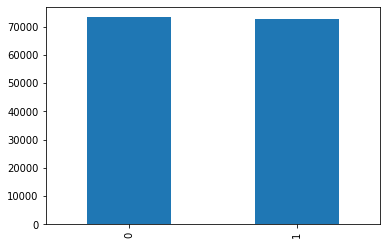

In [12]:
# 레이블의 수치를 그래프로 나타내기
train_data['label'].value_counts().plot(kind='bar')

In [13]:
# 리뷰 데이터 중에 NULL 값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())

True


In [14]:
# Null 값이 존재하므로 어떤 열에 존재하는지 이를 어떻게 바꿔야하는지 조작
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [15]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
# Null 값 제거해서 다시 나타내주기
train_data=train_data.dropna(how='any') #Null값 존재하는 행 제거
print(train_data.isnull().values.any()) #Null값 존재 확인

False


In [17]:
print(len(train_data))

146182


In [18]:
# 정규표현식으로 탈 바꿈 
# 한글 정규표현식
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글 ㄱ-ㅎ / ㅏ- ㅣ / 가-힣 & 띄어쓰기 유지
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
train_data['document']= train_data['document'].str.replace('^ +','') #white space 데이터를 empty value로 변경
train_data['document'].replace('',np.nan, inplace=True) #empty value 값을  NAN 값으로 변경 저장
print(train_data.isnull().sum()) 

id            0
document    789
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [20]:
# 새로나온 결측값 제거
train_data=train_data.dropna(how='any')
print(len(train_data))

145393


In [21]:
# test_data 중복 값 확인
print(len(test_data['document']))
print(test_data['document'].nunique() , test_data['label'].nunique())

50000
49157 2


In [22]:
# test_data에도 마찬가지로 중복 값 제거 / 한글과 공백 외에 나머 공란화 / 공란 값을 결측값으로 변경 / 결측값 제거
test_data.drop_duplicates(subset=['document'],inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].replace("^ +","")
test_data['document'].replace("",np.nan, inplace=True)
test_data=test_data.dropna(how='any')
print('전처리 후 test_data 샘플 갯수:', len(test_data))

전처리 후 test_data 샘플 갯수: 48995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## 3) 토큰화


In [23]:
#불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','라고']

In [24]:
# KoNLPy를 사용해 형태소 분석
# 예시
okt = Okt()
okt.morphs('야 이런 것도 영화라고 만드냐? 내가 만드는 것이 더 낫겠다 ㅋㅋ', stem=True) #stem=True: 단어의 원형으로 바꿔줌 

['야',
 '이렇다',
 '것',
 '도',
 '영화',
 '라고',
 '만들다',
 '?',
 '내',
 '가',
 '만들다',
 '것',
 '이',
 '더',
 '낫다',
 'ㅋㅋ']

In [25]:
X_train =[]
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True) #토큰화 진행
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords] #불용어 제거
  X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [09:07<00:00, 265.39it/s]


In [26]:
# test_data도 형태소 토큰화 진행
X_test =[]
for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True) #토큰화 진행
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords] #불용어 제거
  X_test.append(stopwords_removed_sentence)

100%|██████████| 48995/48995 [03:29<00:00, 234.19it/s]


## 4) 정수 인코딩
- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 함.
- 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어보자.

In [27]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X_train)

# X_train에 대해서 단어별 tokenizer을 했기에 tokenizer.word_index 와 tokenizer.word_counts.items()이 가능해진다.

In [28]:
# tokenizer.word_index는 단어 빈도별 순위를 나타내고, 빈도 순서대로 나타난다.
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '고': 44, '아깝다': 45, '더': 46, '배우': 47, '때': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '재미있다': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '쓰레기': 67, '수': 68, '네': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, '오다': 87, 'ㅋ': 88, 'ㅠㅠ': 89, '많다': 90, '처음': 91, 'ㅋㅋㅋ': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '안되다': 97, '걸': 98, '차다': 99, '나다': 100, '개': 101, '하': 1

In [29]:
# tokenizer.word_counts.items() 은 각 단어별 나온 횟수를 나타낸다.
print(tokenizer.word_counts.items())
print(len(tokenizer.word_counts.items()))

odict_items([('아', 4138), ('더빙', 573), ('진짜', 8312), ('짜증나다', 1010), ('목소리', 374), ('흠', 251), ('포스터', 572), ('보고', 4658), ('초딩', 422), ('영화', 50367), ('줄', 1241), ('오버', 142), ('연기', 6326), ('조차', 242), ('가볍다', 361), ('않다', 7722), ('너', 670), ('무재', 69), ('밓었', 1), ('다그', 75), ('래서', 20), ('보다', 41072), ('추천', 1183), ('다', 10105), ('교도소', 16), ('이야기', 2171), ('구먼', 11), ('솔직하다', 1203), ('재미', 3879), ('없다', 15572), ('평점', 6266), ('조정', 40), ('사이', 222), ('몬페', 2), ('그', 5670), ('익살스럽다', 9), ('돋보이다', 288), ('스파이더맨', 64), ('에서', 6981), ('늙다', 198), ('보이다', 1074), ('커스틴', 4), ('던스트', 2), ('너무나도', 206), ('이쁘다', 1034), ('막', 333), ('걸음', 20), ('마', 236), ('떼다', 151), ('세', 599), ('부터', 1717), ('초등학교', 116), ('학년', 121), ('생인', 6), ('살다', 1173), ('ㅋㅋㅋ', 2448), ('별', 1928), ('반개', 205), ('아깝다', 4419), ('움', 1053), ('원작', 1253), ('긴장감', 832), ('을', 23208), ('제대로', 796), ('살리다', 534), ('욕', 779), ('나오다', 6397), ('이응경', 8), ('길용우', 4), ('연', 882), ('기', 1974), ('생활', 126), ('몇', 697), ('년', 1991

In [30]:
# 빈도수가 낮은 단어들을 자연어처리에서 배제
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0 # 빈도수가 threshold보다 낮은 단어 카운트
rare_freq = 0 # 빈도수가 threshold보다 낮은 단어의 등장빈도 총 합
total_freq = 0 # 훈련데이터의 전체 단어의 등장빈도 총 합

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if value < threshold:
    rare_cnt = rare_cnt+1
    rare_freq = rare_freq + value

print('단어 집합 크기:', total_cnt)
print('등장빈도가 2이하 단어의 수:', rare_cnt)
print('단어집합에서 등장빈도가 2이하 단어의 비율:{}%'.format((rare_cnt/total_cnt) *100))
print('전체 등장 빈도에서 희귀단어 등장 비율:{}%'.format((rare_freq/ total_freq)*100))

단어 집합 크기: 43751
등장빈도가 2이하 단어의 수: 24337
단어집합에서 등장빈도가 2이하 단어의 비율:55.62615711640877%
전체 등장 빈도에서 희귀단어 등장 비율:1.8736805342142602%


In [31]:
# 전체 단어 개수 중 빈도 수 2이하인 단어 제거
# +1을 해주는 이유는 pad[0]= 0부터 시작하기 때문이다.
vocab_size = total_cnt - rare_cnt +1 # 빈도수가 2회 이하인 단어 제외하고 나머지 단어의 갯수
print('단어집합크기:', vocab_size)

# http://doc.mindscale.kr/km/unstructured/qna10.html 참고

단어집합크기: 19415


In [32]:
tokenizer = Tokenizer(vocab_size) #빈도수가 2회 이하인 단어에 대해 제거한 외의 갯수까지만 카운트를 진행하겠다.  
tokenizer.fit_on_texts(X_train) # tokenizer.fit_on_texts(X_train)을 해줌으로서 tokenizer.word_index에는 빈도수가 높은 순으로 단어가 나열되기에 Tokenizer(vocab_size) 즉, 19415개까지 추출해도 문제가 없다.
X_train = tokenizer.texts_to_sequences(X_train) #단어(텍스트)를 정수화 시켜서 나타냄
X_test = tokenizer.texts_to_sequences(X_test)

In [33]:
X_train[:5]

[[50, 453, 16, 259, 658],
 [932, 456, 41, 601, 1, 213, 1448, 24, 960, 674, 19],
 [385, 2443, 2314, 5670, 2, 221, 9],
 [6491, 105, 8117, 217, 56, 4, 26, 3602],
 [1022, 29, 9144, 24, 832, 1, 2578, 21, 1107, 239, 14242, 1075, 253, 239]]

In [34]:
# y_train , y_test 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [35]:
y_train[:5]

array([0, 1, 0, 0, 1])

## 5) 빈 샘플(empty samples)제거
- 전체데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플든은 빈(empty) 상태가 된 것임
- 빈 샘플은 어떤 레이블이 붙어있던 의미가 없으므로 제거해주는 작업을 해줘야 함

In [36]:
# 길이가 0인 샘플들의 인덱스 /  row(행)
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence)<1]

In [37]:
print(drop_train[:])

[28, 414, 1149, 1347, 1572, 1711, 2321, 2345, 2432, 3440, 4289, 4612, 4809, 5021, 5722, 7141, 7790, 9660, 10596, 10973, 11669, 12722, 12766, 12896, 13788, 15427, 16782, 18597, 18626, 19286, 21297, 24351, 24583, 24871, 25031, 25860, 26313, 27110, 27497, 28474, 28600, 28938, 29596, 29618, 30187, 30623, 32218, 32462, 32874, 32885, 33701, 34017, 34216, 34919, 36295, 37099, 37481, 39648, 40010, 40364, 40665, 43207, 43312, 43410, 43838, 43922, 43984, 44094, 44629, 45388, 46359, 46788, 46909, 47456, 47865, 48205, 48827, 51094, 52043, 52778, 52980, 53565, 54640, 54875, 55519, 56274, 56971, 57036, 57277, 57391, 60421, 60439, 60718, 61783, 61949, 62106, 62592, 63085, 63487, 63632, 64232, 64332, 65184, 65481, 66049, 66665, 67697, 67928, 68049, 69478, 70138, 70510, 71315, 72129, 73255, 74008, 74186, 75521, 75921, 77418, 77739, 78027, 78051, 78416, 78887, 79170, 79754, 80550, 80662, 81848, 82858, 84521, 84990, 87275, 87381, 87490, 87497, 88069, 88706, 89022, 89292, 90566, 91144, 92800, 93043, 93533

In [38]:
# 빈 샘플들 제거
X_train = np.delete(X_train, drop_train, axis=0) # np.delete('2차원 배열','삭제할 행','행/열') axis=0이면 행(row), axis=1이면 열(column)
y_train = np.delete(y_train, drop_train, axis =0)
print(len(X_train))
print(len(y_train))

145162
145162


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 6) 패딩
- 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업 진행

In [39]:
# 전체 데이터에서 길이가 가장 긴 리뷰와 전체데이터 길이 분포 확인
print('리뷰 최대 길이:', max(len(review) for review in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train)) / len(X_train)) 


리뷰 최대 길이: 69
리뷰 평균 길이: 10.800174976922335


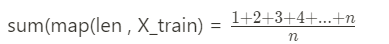

In [40]:
sum(map(len, X_train))

1567775

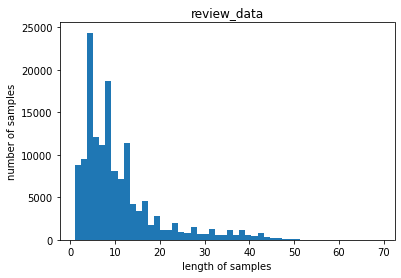

In [41]:
# 리뷰 길이를 시각화
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('review_data')
plt.show()

In [42]:
def below_threshold_len(max_len, nested_list):
  count=0
  for sentence in nested_list:
    if len(sentence) <= max_len:
      count= count+1
  
  print('전체 샘플 중 길이가 {} 이하인 샘플의 비율: {}'.format(max_len,(count/len(nested_list)*100)))

In [43]:
max_len = 32
below_threshold_len(max_len,X_train)

전체 샘플 중 길이가 32 이하인 샘플의 비율: 95.18813463578623


In [44]:
# 샘플의 길이 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 7) LSTM으로 네이버 영화 리뷰 감성 분류하기

In [45]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3901 - acc: 0.8235
Epoch 1: val_acc improved from -inf to 0.84359, saving model to best_model.h5
1815/1815 [==============================] - 23s 8ms/step - loss: 0.3900 - acc: 0.8236 - val_loss: 0.3561 - val_acc: 0.8436
Epoch 2/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3275 - acc: 0.8573
Epoch 2: val_acc improved from 0.84359 to 0.85193, saving model to best_model.h5
1815/1815 [==============================] - 14s 8ms/step - loss: 0.3275 - acc: 0.8573 - val_loss: 0.3371 - val_acc: 0.8519
Epoch 3/15
1809/1815 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.8714
Epoch 3: val_acc improved from 0.85193 to 0.85623, saving model to best_model.h5
1815/1815 [==============================] - 14s 8ms/step - loss: 0.3013 - acc: 0.8714 - val_loss: 0.3313 - val_acc: 0.8562
Epoch 4/15
1809/1815 [============================>.] - ETA: 0s - loss: 0.2823 - acc: 0.8817
Epoch 4: val_acc

In [46]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 6s 4ms/step - loss: 0.3364 - acc: 0.8552

 테스트 정확도: 0.8552


In [47]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [53]:
sentiment_predict('이거 개노잼인데 누가 봄?')

1/1 [==============================] - 0s 19ms/step
99.12% 확률로 부정 리뷰입니다.



In [55]:
sentiment_predict('내가 만들어도 이거보단 잘 만들겠다')

1/1 [==============================] - 0s 24ms/step
88.14% 확률로 부정 리뷰입니다.



In [56]:
sentiment_predict('제가 보고싶었던 영화에요 ㅜㅜ')

1/1 [==============================] - 0s 17ms/step
92.83% 확률로 긍정 리뷰입니다.

